### PREDICTING BASEBALL PLAYERS' STRIKE ZONES USING SUPPORT VECTOR MACHINES
****
**Support Vector Machines** are powerful machine learning models that can make complex decision boundaries. An SVM’s decision boundary can twist and curve to accommodate the training data.

In this project, we will use an SVM trained using a baseball dataset to find the decision boundary of the strike zone.

The **strike zone** can be thought of as a decision boundary that determines whether or not a pitch is a strike or a ball. There is a strict definition of the strike zone — in real life, however, it will vary depending on the umpire or the player at bat.

In [289]:
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import  statcast_batter

In [290]:
# Functions
def make_meshgrid(ax, h=.02):
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def draw_boundary(ax, clf):
    xx, yy = make_meshgrid(ax)
    return plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.5)

## Function to iterate through C and gamma values that optimize the model's accuracy
# Function requires an educated guess range of the C and gamma values
def optimizer(df, c_range, g_range, it= 100, res=[]):
    c_vals= np.random.random_integers(1, c_range, it)
    g_vals= np.random.random_integers(1, g_range, it)
    
    # Classify each strike type
    df['type_1']= df['type'].map({'S':1, 'B':0})
    df= df.dropna(subset= ['plate_x','plate_z','type_1'])
    print(f'record count for {str(df.player_name.unique()[0])}: {df.player_name.count()}')
    print(f'plate_x: Min: {df.plate_x.min()}, Max: {df.plate_x.max()}, Mean: {df.plate_x.mean()}')
    print(f'plate_z: Min: {df.plate_z.min()}, Max: {df.plate_z.max()}, Mean: {df.plate_z.mean()}')
    print("type: ", df.type.unique())
    training_data, validation_data= train_test_split(df, random_state=1)
    cnt= 0 
    for i in c_vals:
        classifier= SVC(kernel= 'rbf', C= i, gamma= g_vals[cnt])
        classifier.fit(training_data[['plate_x','plate_z']],training_data['type_1'])
        sc= classifier.score(validation_data[['plate_x','plate_z']],validation_data['type_1'])
        # print([i,g_vals[cnt],sc])
        res.append([i,g_vals[cnt],sc])
        cnt +=1
        df2= pd.DataFrame(res, columns= ['c_values','g_values','model_score'])
    return df2

## Lets create a function to iterate through our model creation. We'll use this for different players
# Using the best parameters from our optimizer function

def ball_location_svm(params_df, c, g):
    ## Create hit-type classification column
    params_df['type_1']= params_df['type'].map({'S':1, 'B':0})
    params_df= params_df.dropna(subset= ['plate_x','plate_z','type_1'])
    
    ## Split the player's dataset into training and validation datasets
    training_data, validation_data= train_test_split(params_df, random_state=1)
    
    ## Create SVM and train svm model
    classifier= SVC(kernel= 'rbf', C= c, gamma= g)
    classifier.fit(training_data[['plate_x','plate_z']], training_data['type_1'])
    model_sc= classifier.score(validation_data[['plate_x','plate_z']], validation_data['type_1'])
    print("Model Score: ", str(model_sc))
    
    return params_df, classifier # Returns transformed dataset and SVM object

## Let's check the model's accuracy
classifier.score(validation_data[['plate_x','plate_z']],validation_data['type_1'])

## We'll be creating these visualizations a lot, here's write a function for it
def plot_svm(df, classifier):
    chart_title= str(df.player_name.unique()[0])+ " Strike/Ball Postions"
    
    ## Visualize the ball location for player's batting event
    fig, (ax, ax2) = plt.subplots(2, figsize=(10,4))
    fig.tight_layout()
    ax.scatter(df.plate_x, df.plate_z, c= df.type_1, cmap= plt.cm.coolwarm, alpha= .25)
    ax.set_title(chart_title)
    ax.set_ylabel('plate_z')
    
    ## Visualize the new SVM decision boundary
    ax2.scatter(df.plate_x, df.plate_z, c= df.type_1, cmap= plt.cm.coolwarm, alpha= .25)
    ax2.set_title('SVM Decision Boundary')
    ax2.set_xlabel('plate_x')
    ax2.set_ylabel('plate_z')
    # Plot contour figure 
    draw_boundary(ax2, classifier)
    plt.show()
    
    pass

### Data Exploration, Cleaning and Transformations
We’ll be importing several DataFrames related to some of baseball’s biggest stars. This data is available in the *pybaseball* library and reporsitory. We have data on Aaron Judge and Jose Altuve. Judge is one of the tallest players in the league and Altuve is one of the shortest. Their strike zones should be pretty different!

Each row in these DataFrames corresponds to a single pitch that the batter saw in the 2017 season. To begin, let’s take a look at all of the features of a pitch. Print aaron_judge.columns.

We are interested in using the `plate_x`, `plate_z`, and `type` features to predict whether a pitch is a **ball** or **strike**.

In [254]:
## Lookup playerids (key_mlbam): You use this key to call batting stats below

#playerid_lookup('judge', 'aaron') # One of the tallest players in the league
playerid_lookup('altuve') # One of the shortest players in the league

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,altuve,josé,514888,altuj001,altuvjo01,5417,2011.0,2024.0


In [224]:
# Pull Aaron Judge batting stats from the 2017 season
aaron_judge= statcast_batter('2017-04-02', '2017-11-01', 592450)

## Inspect features of interest
print("record count: ", aaron_judge.player_name.count())
print(f'plate_x: Min: {aaron_judge.plate_x.min()}, Max: {aaron_judge.plate_x.max()}, Mean: {aaron_judge.plate_x.mean()}')
print(f'plate_z: Min: {aaron_judge.plate_z.min()}, Max: {aaron_judge.plate_z.max()}, Mean: {aaron_judge.plate_z.mean()}')
print("type: ", aaron_judge.type.unique())

aaron_judge.head(5) # Inspect player dataset 

Gathering Player Data
record count:  3269
plate_x: Min: -3.0, Max: 3.2, Mean: 0.2563299663299663
plate_z: Min: -2.1, Max: 5.77, Mean: 2.2177318640955006
type:  ['S' 'X' 'B']


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,KC,2017-10-21,88.0,-1.27,5.23,"Judge, Aaron",592450,621121,strikeout,swinging_strike,...,4,0,4,Infield shift,Strategic,14.0,0.008,-0.143,NaN,NaN
1,KC,2017-10-21,89.2,-1.31,5.31,"Judge, Aaron",592450,621121,NaN,swinging_strike,...,4,0,4,Infield shift,Strategic,29.0,0.000,-0.053,NaN,NaN
2,KC,2017-10-21,88.2,-1.30,5.40,"Judge, Aaron",592450,621121,NaN,swinging_strike,...,4,0,4,Infield shift,Strategic,35.0,0.000,-0.032,NaN,NaN
3,SI,2017-10-21,95.2,-1.79,5.77,"Judge, Aaron",592450,450203,field_out,hit_into_play,...,0,0,0,Infield shift,Strategic,267.0,0.027,-0.245,NaN,NaN
4,SI,2017-10-21,96.9,-1.94,5.77,"Judge, Aaron",592450,450203,field_out,hit_into_play,...,0,0,0,Infield shift,Strategic,267.0,0.015,-0.204,NaN,NaN


`plate_x` measures how far left or right the pitch is from the center of home plate. If `plate_x` = 0, that means the pitch was directly in the middle of the home plate.

`plate_z` measures how high up the ground the pitch was, that means the pitch was at ground level when it got to the home plate.

`type` feature is either an 'S' for a strike, a 'B' for a ball, or an 'X' for neither (for example, an 'X' could be a hit or an out).

In [234]:
## Clean and Transform the feature data
### Recategorize the type column into an integer column 'S'= 1; 'B'= 0.
aaron_judge['type_1']= aaron_judge['type'].map({'S':1, 'B':0})

### drop missing (NaN) records from the feature dataset 
aaron_judge= aaron_judge.dropna(subset= ['type_1','plate_x','plate_z'])

### Next let's visualize our data
For the scatter plot, we'll use the following parameters:
- **x**:`plate_x`
- **y**:`plate_z`
- **c**:`type`
- **cmap**:`plt.cm.coolwarm`
- **alpha**:`0.25`

Text(0, 0.5, 'plate_z')

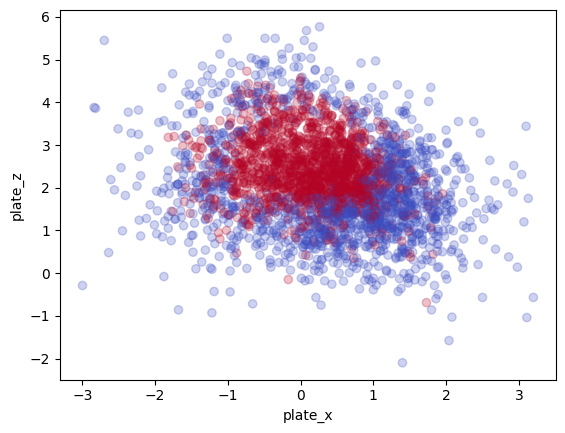

In [29]:
# Feature Plots
fig, ax = plt.subplots()
plt.scatter(aaron_judge.plate_x,aaron_judge.plate_z, c= aaron_judge.type_1, cmap= plt.cm.coolwarm, alpha= .25)
plt.xlabel('plate_x')
plt.ylabel('plate_z')

### Next, let's build a SVM classification model

In [235]:
## Split the Aaron's dataset into training and validation datasets
training_data, validation_data= train_test_split(aaron_judge, random_state=1)

## Create SVC object using the rbf kernel
classifier= SVC(kernel= 'rbf')

## Train the model Fit the dataset to the calssification model: takes your data points and data labels as parameters
classifier.fit(training_data[['plate_x','plate_z']],training_data['type_1'])

## Visualizing the SVM model decision boundaries
fig, ax = plt.subplots()
plt.scatter(aaron_judge.plate_x,aaron_judge.plate_z, c= aaron_judge.type_1, cmap= plt.cm.coolwarm, alpha= .25)
plt.xlabel('plate_x')
plt.ylabel('plate_z')
# Plot contour figure 
draw_boundary(ax, classifier)
plt.show()

SVC()

### Let's optimize and retrain our model to bake in some classification error this time

/Users/Olumedey/Documents/Programming Projects/Python Projects/venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


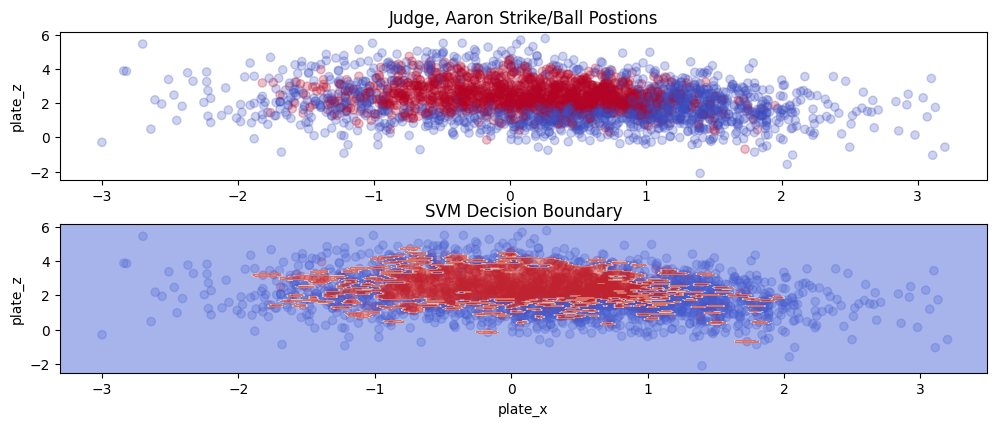

('Model Accuracy:', 0.749656121045392)

In [241]:
## Create SVC object
classifier= SVC(kernel= 'rbf', C= 200, gamma= 200)

## Fit the dataset to the classification model: takes your data points and data labels as parameters
classifier.fit(training_data[['plate_x','plate_z']],training_data['type_1'])

## Visualizing the new SVM decision boundary
plot_svm(aaron_judge, classifier)

## Let's check the model's accuracy
"Model Accuracy:", classifier.score(validation_data[['plate_x','plate_z']],validation_data['type_1'])

### Repeating the process for other Baseball players
***

In [280]:
## Pull a Jose Altuve's player stats for the 2017 season. Use playid_lookup for the last parameter
jose_altuve= statcast_batter('2017-04-02', '2017-11-01', 514888)
## Pull a David Ortiz's player stats for the 2015 season. Use playid_lookup for the last parameter
david_ortiz = statcast_batter('2015-04-02', '2015-11-01', 120074)

Gathering Player Data
Gathering Player Data


In [283]:
## Create a SVM model with initial C and gamma parameters
jose_altuve, svm_josealtuve = ball_location_svm(jose_altuve, 6, 28) # Initial C and gamma parameter guesses
david_ortiz, svm_davidortiz = ball_location_svm(david_ortiz, 6, 28) # Initial C and gamma parameter guesses

Model Score:  0.796
Model Score:  0.7945205479452054


/var/folders/0b/j5_tfk6s0lx6w21rfw19l9cw0000gp/T/ipykernel_58436/1446623797.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  c_vals= np.random.random_integers(1, c_range, it)
/var/folders/0b/j5_tfk6s0lx6w21rfw19l9cw0000gp/T/ipykernel_58436/1446623797.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 50 + 1) instead
  g_vals= np.random.random_integers(1, g_range, it)


record count for Altuve, Jose: 1999
plate_x: Min: -2.92, Max: 3.01, Mean: 0.2984042021010505
plate_z: Min: -1.79, Max: 5.03, Mean: 1.995407703851926
type:  ['S' 'B']
Model Score:  0.86


/Users/Olumedey/Documents/Programming Projects/Python Projects/venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


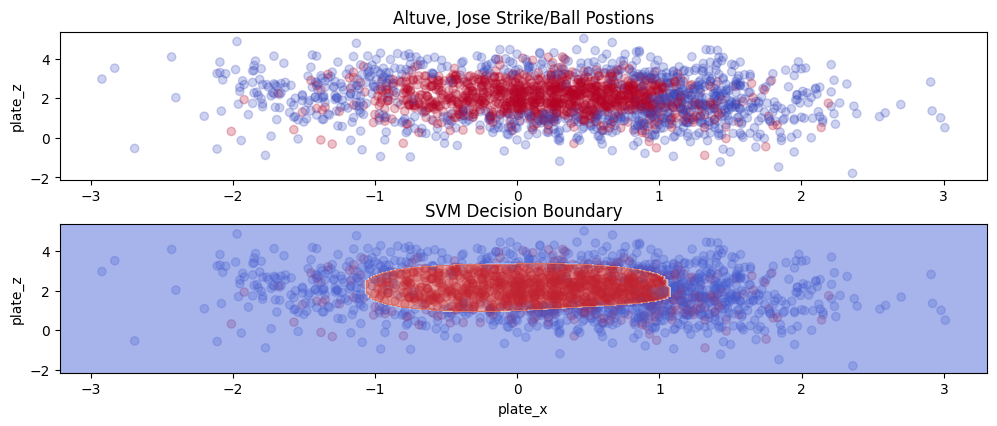

In [288]:
# Optimize Jose Altuve model and Visualize decision boundary
score_check = optimizer(jose_altuve, 10, 50, it= 500)
plot_svm(jose_altuve, ball_location_svm(jose_altuve, 7, 1)[1])

/var/folders/0b/j5_tfk6s0lx6w21rfw19l9cw0000gp/T/ipykernel_58436/1446623797.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  c_vals= np.random.random_integers(1, c_range, it)
/var/folders/0b/j5_tfk6s0lx6w21rfw19l9cw0000gp/T/ipykernel_58436/1446623797.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 50 + 1) instead
  g_vals= np.random.random_integers(1, g_range, it)


record count for Ortiz, David: 2043
plate_x: Min: -7.51, Max: 2.54, Mean: -0.5231424375917768
plate_z: Min: -0.82, Max: 7.86, Mean: 2.3519676945668135
type:  ['S' 'B']
Model Score:  0.837573385518591


/Users/Olumedey/Documents/Programming Projects/Python Projects/venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


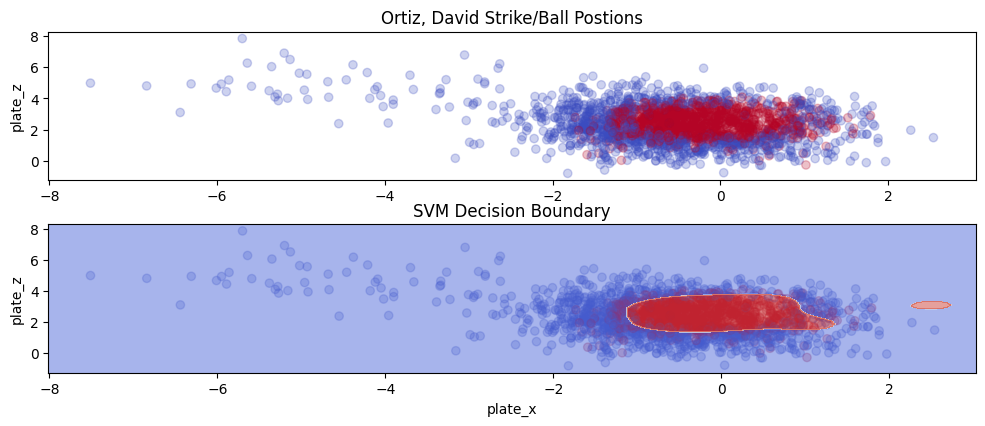

In [287]:
# Optimize David Ortiz model and Visualize decision boundary
score_check = optimizer(david_ortiz, 10, 50, it= 500)
plot_svm(david_ortiz, ball_location_svm(david_ortiz, 7,1)[1])